# Besides routine packages, the obspy and the sequencer packages are needed for this example
## For installing obspy, refer to https://github.com/obspy/obspy/wiki#installation
## For installing sequencer, refer to https://github.com/dalya/Sequencer

In [2]:
import obspy
import glob
import numpy as np
import os
from matplotlib import pyplot as plt
import sequencer

# Reading each trace into a stream

In [3]:
sacdatadir = './DataExample/'
files = glob.glob(sacdatadir+'*.sac')
ntrace = len(files)

st = obspy.core.stream.Stream()

for ifile in files:
    tr = obspy.read(ifile)[0]
    st.append(tr)

# Sequencing 

In [4]:
strmori = st.copy()
npts = strmori[0].stats.npts
dataori = np.zeros((ntrace,npts))
for ii,itrace in enumerate(strmori):
    tdata = itrace.data
# Normalize 
    tdata = (tdata-tdata.min())/(tdata.max()-tdata.min()+1e-6)
    dataori[ii,:] = tdata+2.0

ttime = np.arange(npts)
data = dataori.copy()

estimator_list = ['energy','EMD']
scale_list = [[1,2],[1,2]]
# define the sequencer object with default parameters
seq = sequencer.Sequencer(ttime, data, estimator_list,scale_list=scale_list)


output_path = "sequencer_output_directory"
if not os.path.isdir(output_path):
    os.makedirs(output_path)

final_elongation, final_sequence = seq.execute(output_path,\
                                               to_use_parallelization=True)

estimator_list, scale_list, elongation_list = \
seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

Parallelization is ON. Number of cores: 8
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 19.99442458152771 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 40.581871032714844 seconds
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 23.359599590301514 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 40.365525245666504 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: EMD, scale: 1
in estimator: EMD, scale: 2
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped th

/home/hfang/Publics/anaconda3/envs/seis/lib/python3.7/site-packages/TheSequencer-0.0.5-py3.7.egg/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>
metric=energy, scale=1, elongation: 3.406889921486941
metric=energy, scale=2, elongation: 4.392773593975324
metric=EMD, scale=1, elongation: 2.846165678577151
metric=EMD, scale=2, elongation: 4.2791379586604705


# Plotting

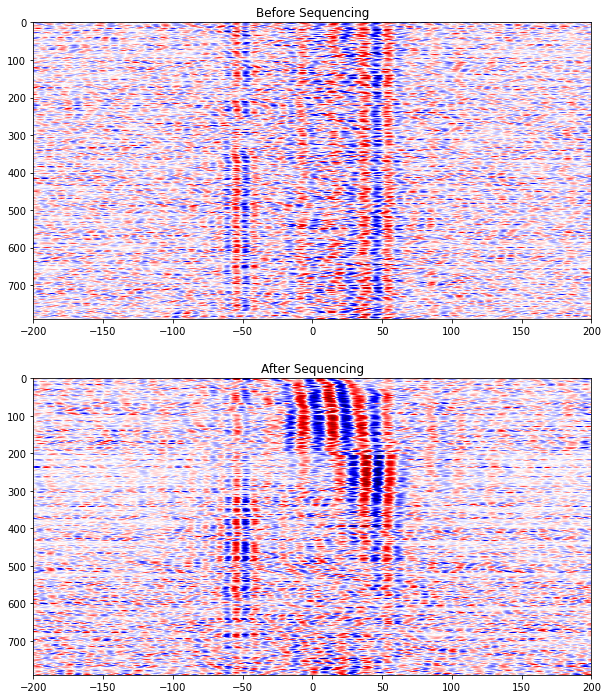

In [12]:
dataori = np.zeros((ntrace,npts))

for ii,itrace in enumerate(strmori):
    itrace.normalize()
    dataori[ii,:] = itrace.data

rdata = dataori[final_sequence]

plt.figure(figsize=(10,12))
plt.subplot(211)
plt.imshow(dataori,aspect='auto',cmap='seismic',extent=(-200,200,len(rdata),0))
plt.title('Before Sequencing')
plt.subplot(212)
plt.imshow(rdata,aspect='auto',cmap='seismic',extent=(-200,200,len(rdata),0))
plt.title('After Sequencing')
plt.show()

# Selective stacking

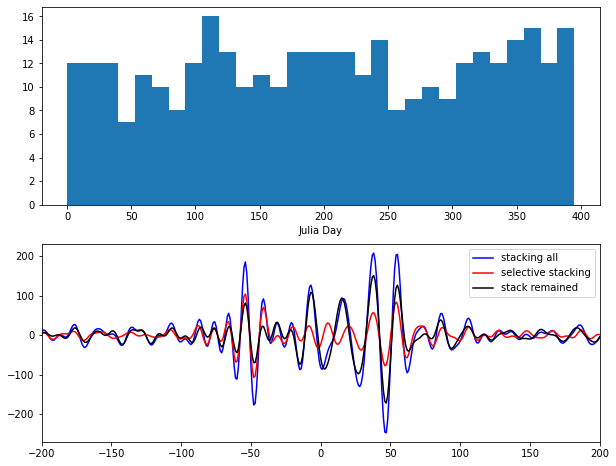

In [13]:
signalidstart = 350
signalidend = 700
cclen = 43200
starttime = obspy.UTCDateTime(st[0].stats.starttime).timestamp
jdays = []
for ii in range(signalidstart,signalidend):
    period = obspy.UTCDateTime(starttime+final_sequence[ii]*cclen)
    jdays.append(period.julday+(period.year-2010)*365)

jdays = jdays-np.min(jdays)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.hist(jdays,bins=30)
plt.title('')
plt.xlabel('Julia Day')


plt.subplot(212)
data3 = np.sum(rdata[signalidstart:signalidend,:],axis=0)
tt = np.linspace(-200,200,401)


odata = np.sum(dataori,axis=0)
ndata = odata-data3

plt.plot(tt,odata,'b')
plt.plot(tt,data3,'r')
plt.plot(tt,ndata,'k')
plt.legend(['stacking all','selective stacking','stack remained'])
plt.xlim(-200,200)

plt.show()

# For comparison with robust stacking, you will need to install StackMaster
## Refer to for installing https://github.com/xtyangpsp/StackMaster

In [10]:
from stackmaster.core import stack
stack_method="robust"
dn = dataori
dstack=stack(dn,method=stack_method)

/home/hfang/Publics/anaconda3/envs/seis/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:21: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a " "future release of tslearn"


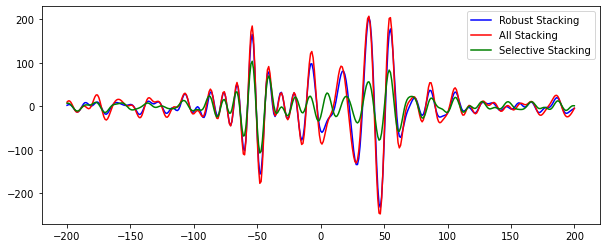

In [15]:
plt.figure(figsize=(10,4))
plt.plot(tt,dstack*500,'b')
plt.plot(tt,odata,'r')
plt.plot(tt,data3,'g')
plt.legend(['Robust Stacking','All Stacking', 'Selective Stacking'])

# Test symmetry

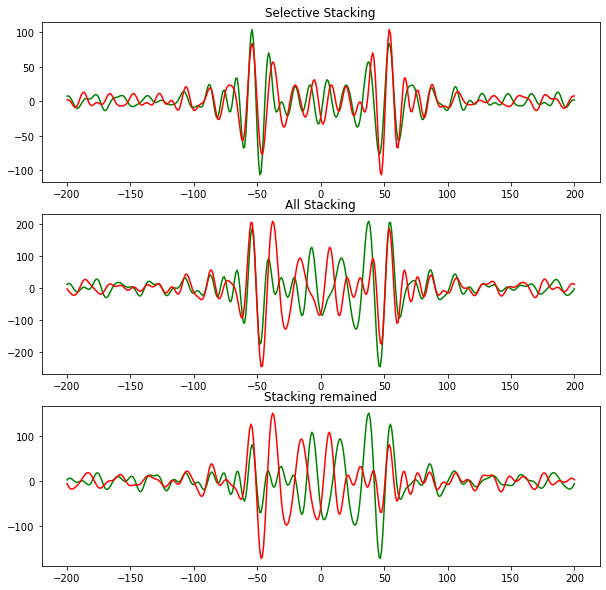

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(tt,data3,'g')
rdata3 = np.flip(data3)
plt.plot(tt,rdata3,'r')
plt.title('Selective Stacking')
plt.subplot(312)
plt.plot(tt,odata,'g')
rodata = np.flip(odata)
plt.plot(tt,rodata,'r')
plt.title('All Stacking')
plt.subplot(313)

plt.plot(tt,ndata,'g')
rndata = np.flip(ndata)
plt.plot(tt,rndata,'r')
plt.title('Stacking remained')
plt.show()